In [1]:
%matplotlib inline

# Basic imports
I believe that all of these imports are used, but after many rounds of re-factoring no guarantees

In [2]:
import glob
from matplotlib import pyplot as plt
import numpy as np
from Bio import SeqIO
from scipy import stats
import re
import random
import pandas as pd
import json

from Bio.Data import CodonTable
from collections import Counter

from bisect import bisect

In [62]:
import matplotlib
matplotlib.rcParams['xtick.labelsize'] = 9
matplotlib.rcParams['ytick.labelsize'] = 9
matplotlib.rcParams['axes.labelsize'] = 9
matplotlib.rcParams['axes.titlesize'] = 10

matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['grid.color'] = '0.8'
matplotlib.rcParams['grid.linewidth'] = '0.5'

matplotlib.rcParams['axes.edgecolor'] = '0.25'
matplotlib.rcParams['xtick.color'] = '0'
matplotlib.rcParams['ytick.color'] = '0'

matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['ytick.major.width'] = 2
matplotlib.rcParams['ytick.major.size'] = 5
matplotlib.rcParams['xtick.major.size'] = 5
# matplotlib.rcParams['axes.spines.right'] = False
# matplotlib.rcParams['axes.spines.left'] = False
# matplotlib.rcParams['axes.spines.top'] = False
# matplotlib.rcParams['axes.spines.bottom'] = False

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.weight']='ultralight'
# matplotlib.rcParams['font.sans-serif'] = ['Computer Modern Sans Serif']
matplotlib.rcParams['axes.axisbelow'] = True

# Some basic functions for working with codons

In [4]:
def get_codon_dicts(n=11):
    GivenCodonTable = CodonTable.unambiguous_dna_by_id[n]
    nucleotides = ['A', 'T', 'C', 'G']
    aa_to_codons = {}
    for first in nucleotides:
        for second in nucleotides:
            for third in nucleotides:
                Codon = first + second + third
                if Codon not in CodonTable.unambiguous_dna_by_id[n].stop_codons:
                    if GivenCodonTable.forward_table[Codon] in aa_to_codons.keys():
                            aa_to_codons[GivenCodonTable.forward_table[Codon]].append(Codon)
                    else:
                        aa_to_codons[GivenCodonTable.forward_table[Codon]] = [Codon]
                else:
                    pass
    codon_to_aa = {}
    for aa, syns in aa_to_codons.items():
        for syn in syns:
            codon_to_aa[syn] = aa
    return aa_to_codons, codon_to_aa


#####These are as described by their names
#####aa_to_codon_dict has key:val pairs of aa:codons(a list), and vice versa for codon_to_aa_dict
aa_to_codon_dict, codon_to_aa_dict = get_codon_dicts()


#####This is getting a list of all codons that have a 4-fold redundant site.
#####i.e. all of the 4-box amino acids, and the 4-fold boxes of the 3 6-box amino acids
temp_codons = []
for aa in ['P', 'T', 'A', 'V', 'G']:
    temp_codons.extend(aa_to_codon_dict[aa])

redundant_codons = ['CTA', 'CTG', 'CTC', 'CTT',\
                    'TCA', 'TCG', 'TCC', 'TCT',\
                    'CGA', 'CGG', 'CGC', 'CGT'] + temp_codons

# Get the sequences for each gene for testing purposes later
Note: this requires establishing a reference genome that you will use later

Return is just a dictionary of dictionaries with the [key : val] : [key : val] pairs being: 

    genome record : gene names

    gene names : gene sequenes

All are strings

In [5]:
base_genome = '511145.12' #This is E. coli K12
species_name = 'Escherichia'
seq_dicty = {}
for infile_name in glob.glob('../Data/Orthologs/Order_Enterobacterales_Mixed/mfastas_nt/*.mfasta'):
    gene_name = infile_name.split('/')[-1].strip('.mfasta')
    records = list(SeqIO.parse(infile_name, 'fasta'))
    for record in records:
        try:
            seq_dicty[record.id][gene_name] = str(record.seq)
        except KeyError:
            seq_dicty[record.id] = {}
            seq_dicty[record.id][gene_name] = str(record.seq)
print('Number of records: {}'.format(len(seq_dicty.keys())))

Number of records: 61


**The following code is used to "switch" the reference genome to identify SD-like sites according to their presence in the `new_base_genome`. Once ran, the rest of the code in this notebook can be run as normal **

For various reasons, this was the simplest solution given file naming conventions and what not. I'm basically just doing things as before but in that final dictionary swapping the E. coli record name out with the new record name and pretending that other record is named E. coli. Clunky, but works. 

From here on out I still refer to `base_genome` (the E. coli identifier) but that `base_genome` now is actually the key for the collection of sequences from `new_base_genome`. 

This is only used/important for the controls of trying to see how results vary according to which species you use to trim, find SD-like sequences, etc.

In [45]:
# #######To analyze a different genome as a reference, run this cell instead and 
# #######just pretend that it's E. coli which makes the code easier
# #######Basic test was to run it with the new_base_genome being equal to the base_genome and showing it
# #######all worked out identically as if you never switched it
# base_genome = '511145.12' #This is E. coli K12

# # #####
# # new_base_genome = '99287.12'
# # species_name = 'Salmonella'

# # #####
# new_base_genome = '1125630.4'
# species_name = 'Klebsiella' 

# #####
# # new_base_genome = '214092.21'
# # species_name = 'Yersinia'

# seq_dicty = {}
# for infile_name in glob.glob('../Data/Orthologs/Order_Enterobacterales_Mixed/mfastas_nt/*.mfasta'):
#     gene_name = infile_name.split('/')[-1].strip('.mfasta')
#     records = list(SeqIO.parse(infile_name, 'fasta'))
#     for record in records:
#         ####For genomes that aren't the old reference or the new reference, proceed as planned
#         if record.id not in [base_genome, new_base_genome]:
#             try:
#                 seq_dicty[record.id][gene_name] = str(record.seq)
#             except KeyError:
#                 seq_dicty[record.id] = {}
#                 seq_dicty[record.id][gene_name] = str(record.seq)
#         ####When you encounter the old reference genome, name it like it's the new one
#         elif record.id == base_genome: ###
#             try:
#                 seq_dicty[new_base_genome][gene_name] = str(record.seq)
#             except KeyError:
#                 seq_dicty[new_base_genome] = {}
#                 seq_dicty[new_base_genome][gene_name] = str(record.seq)
#         ####When you encounter the new genome, name it like it's the old one (i.e. E. coli)
#         elif record.id == new_base_genome:
#             try:
#                 seq_dicty[base_genome][gene_name] = str(record.seq)
#             except KeyError:
#                 seq_dicty[base_genome] = {}
#                 seq_dicty[base_genome][gene_name] = str(record.seq)
                
# print(len(seq_dicty.keys()))

61


## And get dicts to identify conserved amino acid positions and consensus nucleotides

Note that I'm considering an amino acid here as being "conserved" if 60 positions in the alignment have that same amino acid (and it's not a gap). There are 61 total positions so this just gives a little bit of flexibility to definition of conserved.

This takes a minute or so to run, it's not the most efficiently written thing in the world.

In [6]:
conservation_dicty = {}
nt_consensus_dicty = {}
nt_conservation_dicty = {}
for infile_name in glob.glob('../Data/Orthologs/Order_Enterobacterales_Mixed/mfastas_nt/*.mfasta')[:]:
    gene_name = infile_name.split('/')[-1].strip('.mfasta')
    conservation_dicty[gene_name] = []
    nt_consensus_dicty[gene_name] = []
    nt_conservation_dicty[gene_name] = []
    records = list(SeqIO.parse(infile_name, 'fasta'))
    aa_seq_lol = []
    nt_seq_lol = []
    ref_genome_aa = []
    ref_genome_nt = []
    for record in records:
        aa_seq_lol.append(list(str(record.seq.translate(gap='-'))))
        nt_seq_lol.append(list(str(record.seq)))
        if record.id == base_genome:
            ref_genome_aa = list(str(record.seq.translate(gap='-')))
            ref_genome_nt = list(str(record.seq))
    aa_seq_lol = np.array(aa_seq_lol)
    aa_seq_lol = aa_seq_lol.T
    for i, pos in enumerate(aa_seq_lol):
        counter_dict = Counter(pos)
        best = sorted(counter_dict.items(), key=lambda x: x[1])[-1]
        if len(counter_dict.keys()) == 1 and counter_dict[list(counter_dict.keys())[0]] != '-':
            conservation_dicty[gene_name].append('C')
        elif len(counter_dict.keys()) == 2 and best[1]==60 and\
                best[0]!='-' and best[0]==ref_genome_aa[i]:
            conservation_dicty[gene_name].append('C')
        else:
            conservation_dicty[gene_name].append('V')
            
    nt_seq_lol = np.array(nt_seq_lol)
    nt_seq_lol = nt_seq_lol.T
    for i,pos in enumerate(nt_seq_lol):
        counter_dict = Counter(pos)
        nt_consensus_dicty[gene_name].append(sorted(counter_dict.items(), key=lambda x: x[1])[-1][0])
        best = sorted(counter_dict.items(), key=lambda x: x[1])[-1]
        if len(counter_dict.keys()) == 1 and counter_dict[list(counter_dict.keys())[0]] != '-':
            nt_conservation_dicty[gene_name].append('C')
        elif len(counter_dict.keys()) == 2 and best[1]==60 and\
                best[0]!='-' and best[0]==ref_genome_nt[i]:
            nt_conservation_dicty[gene_name].append('C')
        else:
            nt_conservation_dicty[gene_name].append('V')

# Read in substitution rate datasets as separate dictionaries

These are the pre-computed LEISR (HyPhy) substitution rates in `.json` format

In [7]:
dicty_hyphy = {}
for infile_name in glob.glob('../Results/Order_Enterobacterales_Mixed/Hyphy_GTR/*.site-rates.json')[:]:
    gene_name = infile_name.split('/')[-1].strip('.site-rates.json')
    with open(infile_name) as infile:
        site_rate_data = json.load(infile)
    positions = [int(i) for i in site_rate_data['Relative site rate estimates'].keys()]
    rates = []
    for position in range(min(positions), max(positions)+1):
        rates.append(site_rate_data['Relative site rate estimates'][str(position)]['MLE'])
    dicty_hyphy[gene_name] = rates
print('Number of sequences:', len(dicty_hyphy.keys()))

Number of sequences: 1394


## Trim 5' terminal gaps according to the `base_genome` sequence for all dicts instantiated above

In [8]:
print('Average lengths before trimming:', np.mean([len(i) for i in seq_dicty[base_genome].values()]))
print('Average lengths before trimming:', np.mean([len(i) for i in dicty_hyphy.values()]))

for i, j in seq_dicty[base_genome].items():
    if j[0:3] == '---':
        ###Find the first non-gapped character for each gene
        first_bases = []
        for base in ['A', 'T', 'G', 'C']:
            first_bases.append(j.find(base))
        first_base = min(first_bases)
        
        ###For each genome go ahead and truncate those sequences according to that position
        for genome in seq_dicty.keys():
            seq_dicty[genome][i] = seq_dicty[genome][i][first_base:]
            
        ###This is a bit annoying but I need to do that truncation for each of these dictionaries too
        if i in dicty_hyphy.keys():
            dicty_hyphy[i] = dicty_hyphy[i][first_base:]

        if i in conservation_dicty.keys():
            conservation_dicty[i] = conservation_dicty[i][int(first_base/3):]
                
        if i in nt_consensus_dicty.keys():
            nt_consensus_dicty[i] = nt_consensus_dicty[i][first_base:]
            
        if i in nt_conservation_dicty.keys():
            nt_conservation_dicty[i] = nt_conservation_dicty[i][first_base:]
            
print('Average lengths after trimming:', np.mean([len(i) for i in seq_dicty[base_genome].values()]))
print('Average lengths after trimming:', np.mean([len(i) for i in dicty_hyphy.values()]))

Average lengths before trimming: 1105.7195122
Average lengths before trimming: 1105.7195122
Average lengths after trimming: 1059.24533716
Average lengths after trimming: 1059.24533716


## And 3' terminal gaps according to the `base_genome` sequence

Same process as above but in reverse

In [9]:
print('Average lengths before trimming:', np.mean([len(i) for i in seq_dicty[base_genome].values()]))
print('Average lengths before trimming:', np.mean([len(i) for i in dicty_hyphy.values()]))


for i, j in seq_dicty[base_genome].items():
    if j[-3:] == '---':
        last_bases = []
        for base in ['A', 'T', 'G', 'C']:
            last_bases.append(j[::-1].find(base))
        last_base = min(last_bases)
        for genome in seq_dicty.keys():
            seq_dicty[genome][i] = seq_dicty[genome][i][:len(j)-last_base]

        if i in dicty_hyphy.keys():
            dicty_hyphy[i] = dicty_hyphy[i][:len(j)-last_base]

        if i in conservation_dicty.keys():
            conservation_dicty[i] = conservation_dicty[i][:int((len(j)-last_base)/3)]

        if i in nt_consensus_dicty.keys():
            nt_consensus_dicty[i] = nt_consensus_dicty[i][:len(j)-last_base]
        
        if i in nt_conservation_dicty.keys():
            nt_conservation_dicty[i] = nt_conservation_dicty[i][:len(j)-last_base]
            
print('Average lengths after trimming:', np.mean([len(i) for i in seq_dicty[base_genome].values()]))
print('Average lengths after trimming:', np.mean([len(i) for i in dicty_hyphy.values()]))

Average lengths before trimming: 1059.24533716
Average lengths before trimming: 1059.24533716
Average lengths after trimming: 1046.48995696
Average lengths after trimming: 1046.48995696


## Now convert substitution rates to gene-specific relative rates by dividing by the mean of what remains after my trimming

In [10]:
to_delete = []
for gene_name, rates in dicty_hyphy.items():
    if len(rates) == 0:
        to_delete.append(gene_name)
    elif np.mean(rates) == 0:
        to_delete.append(gene_name)

to_delete = list(set(to_delete))
print('Genes that had to be deleted due to insufficient data:')
for i in to_delete:
    del dicty_hyphy[i]
    print(i)
    
for gene_name, rates in dicty_hyphy.items():
    meany = np.mean(rates)
    dicty_hyphy[gene_name] = [i/meany for i in rates]

Genes that had to be deleted due to insufficient data:


# Investigate relationships between the metrics on the full dataset

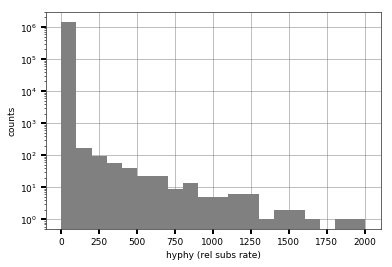

In [11]:
###Distribution of relative substitution rate values
hyphy = []
for key, val in dicty_hyphy.items():
    hyphy.extend(dicty_hyphy[key])   
fig, ax = plt.subplots(figsize=(6,4))
ax.hist(hyphy, 20, color='gray', alpha=1)
ax.set_xlabel('hyphy (rel subs rate)')
ax.set_yscale('log')
ax.set_ylabel('counts')

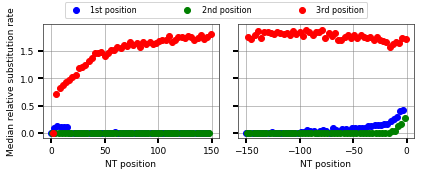

In [12]:
###Median substitution rates at each nt according to the gene ends split by codon position (1,2, or 3)

ivals = []
plot_vals_hyphy = []

length_to_analyze = 150

for i in range(length_to_analyze):
    tempy = []
    for gene_name, vals in dicty_hyphy.items():
        if len(vals) > i:
            tempy.extend([vals[i]])
    plot_vals_hyphy.append(np.median(tempy))
    ivals.append(i)
    
ivals_r = []
plot_vals_hyphy_r = []
for i in range(length_to_analyze, 0, -1):
    tempy = []
    for gene_name, vals in dicty_hyphy.items():
        if len(vals) > i:
            tempy.extend([vals[-i]])
    plot_vals_hyphy_r.append(np.median(tempy))
    ivals_r.append(-i)
    
fig = plt.figure(figsize=(6,2.5))
ax1 = fig.add_subplot(121)
l1, = ax1.plot(ivals[0::3], plot_vals_hyphy[0::3], 'bo', label='1st codon position')
l2, = ax1.plot(ivals[1::3], plot_vals_hyphy[1::3], 'go', label='2nd codon position')
l3, = ax1.plot(ivals[2::3], plot_vals_hyphy[2::3], 'ro', label='3rd codon position')
ax1.set_ylabel('Median relative substitution rate')
ax1.set_xlabel('NT position')
ax2 = fig.add_subplot(122, sharey=ax1)
ax2.plot(ivals_r[0::3], plot_vals_hyphy_r[0::3], 'bo')
ax2.plot(ivals_r[1::3], plot_vals_hyphy_r[1::3], 'go')
ax2.plot(ivals_r[2::3], plot_vals_hyphy_r[2::3], 'ro')
ax2.set_xlabel('NT position')
plt.setp(ax2.get_yticklabels(), visible=False);
fig.subplots_adjust(top=0.85, left=0.1, right=0.9, bottom=0.18)  # create some space below the plots by increasing the bottom-value
plt.figlegend((l1, l2, l3), ('1st position', '2nd position', '3rd position'), bbox_to_anchor=(0.15, 0.88, 0.7, 0.85), loc=3,
           ncol=3, mode="expand", borderaxespad=0, fontsize=8)
plt.tight_layout()
# plt.savefig('../Results/Figures/position_dependent_rates.pdf')

# Defining SD threshold strength
Above was all to process the substitution rates and get them ready to analyze. This short section is just to illustrate the binding thresholds to use for SD sequence classification. Overkill given previous work since these thresholds have been defined but might be of interest for folks to see these distributions

In [13]:
with open('../Data/json-energyRef-CCUCCU.txt') as infile:
    fragment_energy_dict = json.load(infile)
asd_seq = 'CCTCCT'

In [14]:
real_utrs = []
include = 20 ###How far upstream of the start codons should I be looking

###Note we're analyzing the complete E. coli genome here not just our subset that we have orthologs/rates for
genome = list(SeqIO.parse('/Users/adamhockenberry/Projects/Genome_database/Data/GBFs/511145.12.PATRIC.gbf', 'genbank'))
for record in genome:
    for feature in record.features[:]:
        if feature.type == 'CDS':
            if feature.location.strand == 1:
                cds = str(record.seq[feature.location.start:feature.location.end])
            elif feature.location.strand == -1:
                cds = str(record.seq[feature.location.start:feature.location.end].reverse_complement())
            if len(cds)%3 != 0 or len(cds) < 100 or cds[-3:] not in ['TAA', 'TGA', 'TAG']:
                continue
            if feature.location.strand == 1:
                real_utrs.append(record.seq[feature.location.start-include:feature.location.start])
            elif feature.location.strand == -1:
                real_utrs.append(record.seq[feature.location.end:feature.location.end+include].reverse_complement())

In [15]:
randomizations = 20 ###Take those UTRs and shuffle them for a null. This tells you how many shuffles to do
real_utrs = [str(i) for i in real_utrs]
strongest_real = []
strongest_fake = []
strongest_fake_dict = {}
for randomization in range(randomizations):
    strongest_fake_dict[randomization] = []


for utr in real_utrs[:]:
    energy_list = []
    for i in range(0, len(utr)-len(asd_seq)-4):
        fragment = utr[i:i+len(asd_seq)]
        energy = fragment_energy_dict[fragment.replace('T', 'U')]
        energy_list.append(energy)
    strongest_real.append(min(energy_list))
    
    for randomization in range(randomizations):
        energy_list = []
        utr_rand = np.array(list(utr))
        np.random.shuffle(utr_rand)
        utr_rand = ''.join(list(utr_rand))
        for i in range(0, len(utr_rand)-len(asd_seq)-4):
            fragment = utr_rand[i:i+len(asd_seq)]
            energy = fragment_energy_dict[fragment.replace('T', 'U')]
            energy_list.append(energy)
        strongest_fake.append(min(energy_list))
        strongest_fake_dict[randomization].append(min(energy_list))        

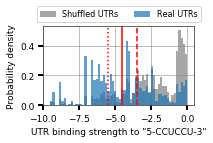

In [16]:
fig = plt.figure(figsize=(3,2))
ax = fig.add_subplot(111)
ax.hist(strongest_fake, 60, normed=True, alpha=0.7, color='gray', label='Shuffled UTRs')
ax.hist(strongest_real, 60, normed=True, alpha=0.7, label='Real UTRs')
ax.axvline(-4.5, c='r')
ax.axvline(-3.5, c='r', linestyle='--')
ax.axvline(-5.5, c='r', linestyle=':')
ax.set_xlabel('UTR binding strength to "5-CCUCCU-3"')
ax.set_ylabel('Probability density')
fig.subplots_adjust(top=0.8, left=0.2, right=0.9, bottom=0.25)  # create some space below the plots by increasing the bottom-value
ax.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.15, 0.9, 0.7, 0.4), fontsize=8)
# plt.savefig('../Results/Figures/SD_threshold.pdf')

**To get some more quantitative information about the number of genes below various thresholds in reality versus in the randomized cases you can interrogate those structures this way**

In [17]:
threshold_of_interest = -4.5
randomization_number_to_check = 4


print(len(strongest_real), len([i for i in strongest_real if i <= threshold_of_interest]))
print(len(strongest_fake_dict[randomization_number_to_check]),\
      len([i for i in strongest_fake_dict[randomization_number_to_check] if i <= threshold_of_interest]))

4525 2095
4525 687


# Lastly, gather some positive control data. i.e. find genes that have another gene directly 3' of them which are thus likely to contain a real SD sequence in their 3' terminus

`preceding_genes` is the relevant thing here, it's a list of all the genes from the whole E. coli genome where an annotated gene is directly downstream. Not necessarily operons, but pretty close

In [18]:
preceding_genes = []

###This defines how far upstream or downstream a given start codon needs to be relative to the previous stop codon 
###in order to consider the previous stop to be a part of a "preceding gene"
flexibility_parameter = 20              




starts_positive_strand = []
starts_negative_strand = []
genome = list(SeqIO.parse('/Users/adamhockenberry/Projects/Genome_database/Data/GBFs/511145.12.PATRIC.gbf', 'genbank'))
for record in genome:
    for feature in record.features:
        if feature.type == 'CDS':
            if feature.location.strand == 1:
                starts_positive_strand.append(feature.location.start)
            elif feature.location.strand == -1:
                starts_negative_strand.append(feature.location.end)
                
flexibility_parameter = 20                
for i,j in enumerate(starts_positive_strand):
    starts_positive_strand[i] = list(range(j-flexibility_parameter,j+flexibility_parameter,1))
for i,j in enumerate(starts_negative_strand):
    starts_negative_strand[i] = list(range(j-flexibility_parameter,j+flexibility_parameter,1))
for record in genome:
    for feature in record.features:
        if feature.type == 'CDS':
            if feature.location.strand == 1:
                end = feature.location.end
                for i in starts_positive_strand:
                    if end in i:
                        preceding_genes.append(feature.qualifiers['locus_tag'][0])
            elif feature.location.strand == -1:
                end = feature.location.start
                for i in starts_negative_strand:
                    if end in i:
                        preceding_genes.append(feature.qualifiers['locus_tag'][0])
                        
preceding_genes = [i for i in seq_dicty[base_genome].keys() if i in preceding_genes]
not_preceding_genes = [i for i in seq_dicty[base_genome].keys() if i not in preceding_genes]

assert len(list(set(preceding_genes))) == len(preceding_genes)
assert len(list(set(not_preceding_genes))) == len(not_preceding_genes)

print(len(preceding_genes), len(not_preceding_genes), len(seq_dicty[base_genome].keys()))

391 1003 1394


**Make a basic little dictionary just grabbing the ending indices of all gene sequences**

In [19]:
end_nts_to_grab = -50 ###This number could be more specific to each gene but it's not the point of this paper
three_prime_limitation_dict = {}
for gene_name, nts in seq_dicty[base_genome].items():
    three_prime_limitation_dict[gene_name] = list(range(len(nts)-end_nts_to_grab, len(nts)))

# Dig into data to test for conservation of SD motifs relative to null controls

**After running all of the above code, you should now have loaded in a lot of dictionaries and data structures. Most notably, however we have the substitution rates and the gene sequences, as well as dictionaries of conservation, a sense of what threshold to use for SD-like sequence definition, a list of genes that we think we can use as positive controls, etc.**

So now, this code performs an analysis on ONLY 4-fold redundant nucleotide sites that are within an aSD sequence binding site (where within is one of the internal 4 nts of the 6-mer). Critically, for each one that we find, we compare the substitution rate at that site to the same synonymous codon or nucleotide context somewhere else in the same gene (if possible). With these paired lists, we can accurately compare whether there are substitution rate differences while ruling out gene-specific effects as well as (independenty) codon and mutational context effects.

In [81]:
####These are a suite of associated functions to keep things organized and running relatively quickly/efficiently
####As always, some of this could likely be written better, faster, more concisely, etc. but I've done extensive
####testing to make sure that there are no major bugs or areas of concern

def get_sd_sites(nt_sequence, asd_seq, threshold, fragment_energy_dict,\
                 position_limitation_list, upper_threshold=-20, min_position=100, max_position=-50):
    '''
    This function is here to identify the SD-like sites that I'm going to analyze for a given gene sequence
    that is a string. It returns:
    1) a list of all SD-like nucldotides within the gene
    2) a list of all the beginnings of SD-like sequences within the gene
    3) a list of all the binding energies (for all sequential x-mers) across the entire sequence 
    4) the list of codons for the gene
    '''
    codon_list = [nt_sequence[nt:nt+3] for nt in range(0, len(nt_sequence), 3)]
    energy_list = []
    for i in range(0, len(nt_sequence)-len(asd_seq)):
        fragment = nt_sequence[i:i+len(asd_seq)]
        if fragment.count('-') == 0:
            energy = fragment_energy_dict[fragment.replace('T', 'U')]
            energy_list.append(energy)
        else:
            energy_list.append(np.nan)
    #######This gets all positions below the given threshold
    sd_positions_all_nts = [list(range(i, i+len(asd_seq))) for i,j in enumerate(energy_list) if j < threshold]
    sd_positions_all_nts = [item for sublist in sd_positions_all_nts for item in sublist]
    sd_positions_all_nts = list(set(sd_positions_all_nts))
    
    #######This gets all "start" position within the threshold range. Subtle but important difference
    if position_limitation_list != False:
        sd_positions_start = np.array([i for i,j in enumerate(energy_list) if upper_threshold < j and j < threshold and i in position_limitation_list])
    else:
        sd_positions_start = np.array([i for i,j in enumerate(energy_list) if upper_threshold < j and j < threshold and i > min_position and i < len(nt_sequence)+max_position])
    
    ###THIS IS REALLY IMPORTANT: SHUFFLE THE SEQUENCES SO THAT WHEN I ITERATE THROUGH THEM
    ###I'M NOT SELECTING THE SAME ONES EVERY TIME
    np.random.shuffle(sd_positions_start) 
    return sd_positions_all_nts, sd_positions_start, energy_list, codon_list

def get_control_sites_codon(nt_sequence, codon_list, sd_positions_all_nts,\
                            analyzed_positions, codon, min_position=100, max_position=-50):
    '''
    This function selects the control sites for the codon control given the nt_sequence, the codon_list, 
    the position of all SD nucleotides, which positions have already been selected as controls, and of course
    the codon of interest
    '''
    control_sites = [site*3+2 for site, x in enumerate(codon_list) if x == codon]
    control_sites = [site for site in control_sites if site > min_position and site < len(nt_sequence)+max_position]
    control_sites = [site for site in control_sites if site not in sd_positions_all_nts]
    control_sites = [site for site in control_sites if site not in analyzed_positions]
    return control_sites

def get_control_sites_tri_nt(nt_sequence, codon_list, sd_positions_all_nts,\
                             analyzed_positions, tri_nt, redundant_codons, min_position=100, max_position=-50):
    '''
    This function selects the control sites for what I call the tri-nucleotide control given the nt_sequence, 
    the codon_list, the position of all SD nucleotides, which positions have already been selected as controls, 
    and of course the tri-nucleotide sequence of interest. Additionally it requires the list of 4-fold redundant codons
    to ensure that the tri-nucleotide site I select belongs to a redundant codon
    '''
    control_sites = [m.start()+1 for m in re.finditer(tri_nt, nt_sequence)]
    control_sites = [site for site in control_sites if site > min_position and site < len(nt_sequence)+max_position]
    control_sites = [site for site in control_sites if site%3 == 2]
    control_sites = [site for site in control_sites if nt_sequence[site-2:site+1] in redundant_codons]
    control_sites = [site for site in control_sites if site not in sd_positions_all_nts]
    control_sites = [site for site in control_sites if site not in analyzed_positions]
    return control_sites

def get_possible_energies(fragment, codon, all_codons, modifier, fragment_energy_dict):
    '''
    This function comes into play a little later and is a subtle point but for any given x-mer fragment that
    I identify as a SD-like sequence with a 4-fold redundant nucleotide site inside, I am getting a list of the
    possible binding energies to the aSD sequence for all codon substitutions to essentially see if the current
    nucleotide makes a strong or a weak SD-like sequence
    '''
    possible_energies = []
    for possible_codon in all_codons:
        if possible_codon != codon:
            if modifier == 2:
                possible_fragment = possible_codon + fragment[-3:]
            elif modifier == 3:
                possible_fragment = fragment[0] + possible_codon + fragment[-2:]
            elif modifier == 1:
                possible_fragment = possible_codon[-2:] + fragment[-4:]
            elif modifier == 4:
                possible_fragment = fragment[0:2] + possible_codon + fragment[-1]
            assert len(possible_fragment) == 6
            possible_energies.append(fragment_energy_dict[possible_fragment.replace('T', 'U')])
    return possible_energies


def paired_nt_analysis(dicty_to_analyze,\
                      genome_seq_dicty,\
                      fragment_energy_dict,\
                      asd_seq,\
                      conservation_dicty,\
                      nt_conservation_dicty,\
                      redundant_codons=redundant_codons,\
                      threshold=-4.5,\
                      upper_threshold=-20,\
                      min_position=100,\
                      max_position=-50,\
                      subset_names=False,\
                      only_conserved_aa=False,\
                      position_limitation_dict=False,\
                      internal_control='',\
                      nt_strength_restriction=''):
    '''
    This is my rather monsterous main function that has a lot of flags so be careful! 
    However, its complexity provides the benefit that I know all analyses that follow are run through
    this common function. For the most part, all of these flags are ultimately limiting the 
    data according to various criteria at different points in the pipeline, and are noted as comments below.
    '''
    sds = []
    others = []
    analyzed_sd_dict = {}
    analyzed_control_dict = {}
    
    all_sds = []
    all_others = []
        
    for gene_name, seq in list(genome_seq_dicty.items())[:]:

        analyzed_sds = []
        analyzed_controls = []
        
        gene_sds = []
        gene_others = []
        
        ###########Skip ahead if this gene is not in my dictionary to analyze
        if gene_name not in dicty_to_analyze.keys():
            continue
        ###########Skip ahead if I want to only analyze a subset and this gene isn't in it
        if subset_names:
            if gene_name not in subset_names:
                continue
        ###########Hang on to this information for now to eventually limit where in the gene to consider, if relevant
        position_limitation_list = False
        if position_limitation_dict != False:
            position_limitation_list = position_limitation_dict[gene_name]
            
        ##################################################################################################
        ###GET LOCATIONS OF ALL SD-LIKE SEQUENCES THAT I MIGHT WANT TO ANALYZE FOR THIS GENE       
        sd_positions_all_nts, sd_positions_start, energy_list, codon_list =\
                        get_sd_sites(seq, asd_seq, threshold, fragment_energy_dict,\
                                     position_limitation_list=position_limitation_list,\
                                     upper_threshold=upper_threshold, min_position=min_position,\
                                     max_position=max_position)

        for i in sd_positions_start:
            energy = energy_list[i]
            modifiers = []
            ###This accounting below is to determine the frame. Analysis is only done on the internal
            ###4 sites of a given 6-mer so depending on the frame there are only a few possible 3rd-position
            ###codon sites
            if i%3 == 0:
                modifiers = [2]
            elif i%3 == 2:
                modifiers = [3]
            elif i%3 == 1:
                modifiers = [1,4]
            for modifier in modifiers:
                ##################################################################################################
                #If I'm only considering particular regions, make sure that this location is one of them. Otherwise, meh.
                if position_limitation_dict != False:
                    if i+modifier not in position_limitation_dict[gene_name]:
                        continue

                analyzed_positions = analyzed_sds + analyzed_controls
                
                ##################################################################################################
                #Make sure that the location is conserved, and if TRINT that the next position is conserved
                if only_conserved_aa == True:
                    if conservation_dicty[gene_name][int(np.floor((i+modifier)/3.))] != 'C':
                        continue
                if only_conserved_aa == True and internal_control=='TRINT':
                    if nt_conservation_dicty[gene_name][i+modifier+1] != 'C':
                        continue
                
                codon = seq[i+modifier-2:i+modifier+1]
                tri_nt = seq[i+modifier-1:i+modifier+2]
                if codon in redundant_codons:
                    ##################################################################################################
                    ###RUN A FILTER ACCORDING TO WHETHER I ONLY WANT TO SELECT STRONGEST OR WEAKEST POSSIBLE SEQUENCES
                    if nt_strength_restriction == 'None':
                        pass
                    else:
                        fragment = genome_seq_dicty[gene_name][i:i+len(asd_seq)]
                        all_codons = aa_to_codon_dict[codon_to_aa_dict[codon]]
                        all_codons = [temp for temp in all_codons if temp[:2] == codon[:2]]###Dealing with 6-fold redundant codons
                        possible_energies = get_possible_energies(fragment, codon, all_codons, modifier, fragment_energy_dict)
                        possible_energies = sorted(possible_energies)
                        assert len(possible_energies) == 3, possible_energies
                        if energy in possible_energies:###Because I don't know how to treat these cases, toss them and move on
                            continue
                        insertion_point = bisect(possible_energies, energy)
                        #################################################################
                        ###Below will get rid of the ones that aren't included in my flag
                        if int(nt_strength_restriction) != insertion_point:
                            continue 
                            
                    ##################################################################################################
                    ###GET CONTROL SITES ACCORDING TO EITHER OF TWO DIFFERENT NULL MODELS
                    if internal_control == 'CODON':
                        control_sites =\
                            get_control_sites_codon(seq, codon_list, sd_positions_all_nts, analyzed_positions, codon,\
                                                   min_position=min_position, max_position=max_position)
                    elif internal_control == 'TRINT':
                        control_sites =\
                            get_control_sites_tri_nt(seq, codon_list, sd_positions_all_nts, analyzed_positions, tri_nt, redundant_codons,\
                                                    min_position=min_position, max_position=max_position)
                    else:
                        print("YOU DID NOT PROPERLY SPECIFY A CONTROL METHOD, VALID VALUES ARE 'CODON' AND 'TRINT'")
                        break
                    ##################################################################################################
                    ###Limit the controls based on conservation of the amino acid
                    if only_conserved_aa == True and internal_control == 'CODON':
                        control_sites = [site for site in control_sites if conservation_dicty[gene_name][int(np.floor(site/3.))] == 'C']
                    elif only_conserved_aa == True and internal_control == 'TRINT':
                        control_sites = [site for site in control_sites if conservation_dicty[gene_name][int(np.floor(site/3.))] == 'C']
                        control_sites = [site for site in control_sites if nt_conservation_dicty[gene_name][site+1] == 'C']

                    ##################################################################################################
                    ###IF ALL LOOKS WELL CHOOSE A CONTROL AND GO FORWARD WITH ANALYSIS
                    ##################################################################################################                    
                    ###First keep track of all the sites that I could potentially analyze
                    gene_sds.append(i+modifier)
                    gene_others.extend(control_sites)
                    if len(control_sites) > 0 and i+modifier not in analyzed_positions:
#                         ###Temporary code to test selection of only the closest site to the one under investigation
#                         choice_dists = [(temp_choice, abs(temp_choice-i+modifier)) for temp_choice in control_sites]
#                         choice_dists.sort(key = lambda x: x[1])
#                         choice = choice_dists[0][0]
                        
                        choice = random.choice(control_sites)
                        sds.append(dicty_to_analyze[gene_name][i+modifier])
                        others.append(dicty_to_analyze[gene_name][choice])
                        analyzed_sds.append(i+modifier)
                        analyzed_controls.append(choice)
                        #######################################################################
                        ###Fail safe to make sure I chose the right codons and context controls
                        if internal_control == 'CODON':
                            assert seq_dicty[base_genome][gene_name][i+modifier-2:i+modifier+1] == seq_dicty[base_genome][gene_name][choice-2:choice+1]
                        if internal_control == 'TRINT':
                            assert seq_dicty[base_genome][gene_name][i+modifier-1:i+modifier+2] == seq_dicty[base_genome][gene_name][choice-1:choice+2]
        gene_sds = list(set(gene_sds))
        gene_others = list(set(gene_others))
        
        all_sds.extend([dicty_to_analyze[gene_name][position] for position in gene_sds])
        all_others.extend([dicty_to_analyze[gene_name][position] for position in gene_others])
        analyzed_sd_dict[gene_name] = analyzed_sds
        analyzed_control_dict[gene_name] = analyzed_controls
    return sds, others, analyzed_sd_dict, analyzed_control_dict, all_sds, all_others

# Run the analysis
There are a lot of flags at the top here but the analysis below is essentially the analysis that is used throughout the manuscript. Thresholds, null models, etc can all be assessed by changing flags in the folloiwng cell to accomplish various analyses and controls that were depicted in the manuscript.

This isn't optimized for speed in anyway, and will take a little while to run but nothing too long. Each iteration is printed to the screen to check progress.

In [150]:
dicty_to_analyze = dicty_hyphy #####If this changes, make sure to manually change file_name_modifiers
threshold=-4.5
upper_threshold=-20.0

###If I want to analyze a subset of genes
# subset_names=preceding_genes
# subset_names=not_preceding_genes
subset_names=False ###Changing this requires manual tinkering of file_name_modifiers below

###Whether or not to limit analysis to only conserved amino acids which isn't strictly necessary
only_conserved_aa=True

###Position limitations on where to look?
# position_limitation_dict=three_prime_limitation_dict
position_limitation_dict=False

###My two controls, this shouldn't be touched
controls=('CODON', 'TRINT')

###This refers to whether or not I want to restrict analysis to only look at the nt's where a replacement
###will make a weaker SD-like sequence
nt_strength_restriction='None' ###Valid values are: 'None', '0', '1', '2', '3'


mean_randomizations = 2

#########################################################
####Putative aSD sequence to use in considering hybridization energies
with open('../Data/json-energyRef-CCUCCU.txt') as infile:
    fragment_energy_dict = json.load(infile)
asd_seq = 'CCUCCU'
#########################################################
#########################################################
#
#
#
#########################################################
####For writing files later
file_name_modifiers = '{}_{}_Threshold={}to{}_Conserved={}_NtRestriction={}'.format('hyphy', species_name, upper_threshold, threshold, only_conserved_aa, nt_strength_restriction)
if subset_names != False or position_limitation_dict != False:
    file_name_modifiers = file_name_modifiers + '_Subset=preceding_Position_limitation=3prime'
#########################################################
#########################################################
#
#
#########################################################
#These containers are for keeping track of randomizations to assess significance
actual_ratios_codon = []
shuffled_ratios_codon = []
actual_ratios_trint = []
shuffled_ratios_trint = []

actual_pvals_codon = []
shuffled_pvals_codon = []
actual_pvals_trint = []
shuffled_pvals_trint = []


for i in range(mean_randomizations):
    print('#####{}'.format(i))
    sds_codon, others_codon, analyzed_sd_dict_codon, analyzed_ctrl_dict_codon, all_sds_codon, all_others_codon = paired_nt_analysis(dicty_to_analyze,\
                                     seq_dicty[base_genome],\
                                     fragment_energy_dict,\
                                     asd_seq,\
                                     conservation_dicty,\
                                     nt_conservation_dicty,\
                                     threshold=threshold,\
                                     upper_threshold=upper_threshold,\
                                     subset_names=subset_names,\
                                     only_conserved_aa=only_conserved_aa,\
                                     position_limitation_dict=position_limitation_dict,\
                                     internal_control=controls[0],\
                                     nt_strength_restriction=nt_strength_restriction)
    actual_ratios_codon.append(np.mean(sds_codon)/np.mean(others_codon))
    print('Lengths:{}, {}, Means:{}, {}, Ratio:{}'.format(len(sds_codon), len(others_codon),\
                                                          np.mean(sds_codon), np.mean(others_codon),\
                                                          np.mean(sds_codon)/np.mean(others_codon)))
    t_val, p_val = stats.wilcoxon(sds_codon, others_codon)
    actual_pvals_codon.append(p_val)

    combined = sds_codon + others_codon
    random.shuffle(combined)
    random_sds = combined[:len(sds_codon)]
    random_others = combined[len(sds_codon):]
    shuffled_ratios_codon.append(np.mean(random_sds)/np.mean(random_others))
    t_val_rand, p_val_rand = stats.wilcoxon(random_sds, random_others)
    shuffled_pvals_codon.append(p_val_rand)


    sds_trint, others_trint, analyzed_sd_dict_trint, analyzed_ctrl_dict_trint, all_sds_trint, all_others_trint = paired_nt_analysis(dicty_to_analyze,\
                                     seq_dicty[base_genome],\
                                     fragment_energy_dict,\
                                     asd_seq,\
                                     conservation_dicty,\
                                     nt_conservation_dicty,\
                                     threshold=threshold,\
                                     upper_threshold=upper_threshold,\
                                     subset_names=subset_names,\
                                     only_conserved_aa=only_conserved_aa,\
                                     position_limitation_dict=position_limitation_dict,\
                                     internal_control=controls[1],\
                                     nt_strength_restriction=nt_strength_restriction)
    actual_ratios_trint.append(np.mean(sds_trint)/np.mean(others_trint))
    print('Lengths:{}, {}, Means:{}, {}, Ratio:{}'.format(len(sds_trint), len(others_trint),\
                                                          np.mean(sds_trint), np.mean(others_trint),\
                                                          np.mean(sds_trint)/np.mean(others_trint)))
    t_val, p_val = stats.wilcoxon(sds_trint, others_trint)
    actual_pvals_trint.append(p_val)

    combined = sds_trint + others_trint
    random.shuffle(combined)
    random_sds = combined[:len(sds_trint)]
    random_others = combined[len(sds_trint):]
    shuffled_ratios_trint.append(np.mean(random_sds)/np.mean(random_others))
    
    t_val_rand, p_val_rand = stats.wilcoxon(random_sds, random_others)
    shuffled_pvals_trint.append(p_val_rand)

#####0
Lengths:1740, 1740, Means:3.154052373916312, 2.9332728152960525, Ratio:1.0752673114716664
Lengths:1161, 1161, Means:3.1198528580601206, 2.4564687458918653, Ratio:1.270055995329752
#####1
Lengths:1740, 1740, Means:3.1262826484280706, 2.9131255460587204, Ratio:1.073171272229492
Lengths:1161, 1161, Means:3.1248021149171668, 2.4766054262081285, Ratio:1.261727880367878


**Save analysis data to files for subsequent stats / visualization elsewhere**

In [39]:
df = pd.DataFrame({'Actual_rats_codon':actual_ratios_codon})
df['Shuffled_rats_codon'] = shuffled_ratios_codon
df['Actual_rats_trint'] = actual_ratios_trint
df['Shuffled_rats_trint'] = shuffled_ratios_trint

df['Actual_pvals_codon'] = actual_pvals_codon
df['Shuffled_pvals_codon'] = shuffled_pvals_codon
df['Actual_pvals_trint'] = actual_pvals_trint
df['Shuffled_pvals_trint'] = shuffled_pvals_trint

df['N_(codon)'] = len(sds_codon)
df['N_(trint)'] = len(sds_trint)
df.to_csv('../Results/Dataframes/df_{}_ratios.csv'.format(file_name_modifiers), index=False)


dfA = pd.DataFrame({'SD-like(codon)':all_sds_codon})
dfB = pd.DataFrame({'SD-like(trint)':all_sds_trint})
dfC = pd.DataFrame({'Control\n(codon)':all_others_codon})
dfD = pd.DataFrame({'Control\n(context)':all_others_trint})

df = pd.concat([dfA,dfB,dfC,dfD], axis=1)
df.to_csv('../Results/Dataframes/df_{}_all.csv'.format(file_name_modifiers), index=False)

**For an SI fig/sanity check, plot the distribution of analyzed sites per gene**

Total sites (Codon, Trint): 1740 1161
Max per gene: 27 18
Max fraction: 0.015517241379310345 0.015503875968992248
Total genes with sites: 494 432
Mean per gene: 1.24820659971 0.832855093257
Median per gene: 0.0 0.0


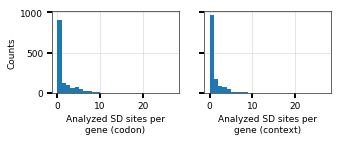

In [151]:
n_per_gene_sd_codon = []
n_per_gene_control_codon = []
for key in analyzed_sd_dict_codon.keys():
    n_per_gene_sd_codon.append(len(analyzed_sd_dict_codon[key]))
    n_per_gene_control_codon.append(len(analyzed_ctrl_dict_codon[key]))
    
assert n_per_gene_sd_codon == n_per_gene_control_codon


n_per_gene_sd_trint = []
n_per_gene_control_trint = []
for key in analyzed_sd_dict_trint.keys():
    n_per_gene_sd_trint.append(len(analyzed_sd_dict_trint[key]))
    n_per_gene_control_trint.append(len(analyzed_ctrl_dict_trint[key]))

assert n_per_gene_sd_trint == n_per_gene_control_trint

combined = n_per_gene_sd_codon + n_per_gene_sd_trint
hist, bin_edges = np.histogram(combined, bins=max(combined))
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(5,1.5), sharex=True, sharey=True)
ax[0].hist(n_per_gene_sd_codon, bins=bin_edges)
ax[1].hist(n_per_gene_sd_trint, bins=bin_edges)
ax[0].set_ylabel('Counts')
ax[0].set_xlabel('Analyzed SD sites per\ngene (codon)')
ax[1].set_xlabel('Analyzed SD sites per\ngene (context)')
plt.savefig('../Results/Figures/per_gene_dists.pdf', bbox_inches='tight')

print('Total sites (Codon, Trint):', sum(n_per_gene_sd_codon), sum(n_per_gene_sd_trint)) 
print('Max per gene:', max(n_per_gene_sd_codon), max(n_per_gene_sd_trint))
print('Max fraction:', max(n_per_gene_sd_codon)/sum(n_per_gene_sd_codon),\
      max(n_per_gene_sd_trint)/sum(n_per_gene_sd_trint))
print('Total genes with sites:', len([i for i in n_per_gene_sd_codon if i != 0]),\
      len([i for i in n_per_gene_sd_trint if i != 0])) 
print('Mean per gene:', np.mean(n_per_gene_sd_codon), np.mean(n_per_gene_sd_trint))
print('Median per gene:', np.median(n_per_gene_sd_codon), np.median(n_per_gene_sd_trint))

# Testing gene expression differences systematically

### First, tediously get a dictionary linking names in PATRIC annotations to names in RefSeq

In [83]:
genome_ref = list(SeqIO.parse('/Users/adamhockenberry/Projects/Genome_database/Data/GBFs/511145.12.RefSeq.gbf', 'genbank'))[0]
genome_pat = list(SeqIO.parse('/Users/adamhockenberry/Projects/Genome_database/Data/GBFs/511145.12.PATRIC.gbf', 'genbank'))[0]

locs_dict_ref_positive = {}
locs_dict_ref_negative = {}

locs_dict_pat_positive = {}
locs_dict_pat_negative = {}

ref_genome_seq_ref_dict = {}
ref_genome_seq_patric_dict = {}

for feature_pat in genome_pat.features[:]:
    if feature_pat.type == 'CDS':
        name_pat = feature_pat.qualifiers['locus_tag'][0]
        strand_pat = feature_pat.strand
        if strand_pat == 1:
            locs_dict_pat_positive[name_pat] = list(range(feature_pat.location.start, feature_pat.location.end))
            ref_genome_seq_patric_dict[name_pat] = genome_pat.seq[feature_pat.location.start:feature_pat.location.end]
        elif strand_pat == -1:
            locs_dict_pat_negative[name_pat] = list(range(feature_pat.location.start, feature_pat.location.end))
            ref_genome_seq_patric_dict[name_pat] = genome_pat.seq[feature_pat.location.start:feature_pat.location.end].reverse_complement()

for feature_ref in genome_ref.features[:]:
    if feature_ref.type == 'CDS':
        name_ref = feature_ref.qualifiers['locus_tag'][0]
        strand_ref = feature_ref.strand
        if strand_ref == 1:
            locs_dict_ref_positive[name_ref] = list(range(feature_ref.location.start, feature_ref.location.end))
            ref_genome_seq_ref_dict[name_ref] = genome_ref.seq[feature_ref.location.start:feature_ref.location.end]

        elif strand_ref == -1:
            locs_dict_ref_negative[name_ref] = list(range(feature_ref.location.start, feature_ref.location.end))
            ref_genome_seq_ref_dict[name_ref] = genome_ref.seq[feature_ref.location.start:feature_ref.location.end].reverse_complement()
            
print(len(locs_dict_pat_positive.keys()))
print(len(locs_dict_pat_negative.keys()))
print(len(locs_dict_ref_positive.keys()))
print(len(locs_dict_ref_negative.keys()))   

reference_name_dict = {}
for name_pat, loc_pat in sorted(locs_dict_pat_positive.items()):
    for name_ref, loc_ref in sorted(locs_dict_ref_positive.items()):
        if len(set(loc_pat)&set(loc_ref)) / len(loc_pat) > 0.9: #######Make sure that 90% of the location matches
#         if loc_pat == loc_ref:
            reference_name_dict[name_ref] = name_pat
            del locs_dict_ref_positive[name_ref]
            break
            
for name_pat, loc_pat in sorted(locs_dict_pat_negative.items()):
    for name_ref, loc_ref in sorted(locs_dict_ref_negative.items()):
        if len(set(loc_pat)&set(loc_ref)) / len(loc_pat) > 0.9: ######Again stick with that 90% cutoff
#         if loc_pat == loc_ref:
            reference_name_dict[name_ref] = name_pat
            del locs_dict_ref_negative[name_ref]
            break
print(len(reference_name_dict.keys()), len(ref_genome_seq_patric_dict.keys()), len(ref_genome_seq_ref_dict.keys()))

2246
2303
2108
2213
4139 4549 4321


### Load in dataset of protein abundance from PaxDB (integrated dataset)

In [84]:
df = pd.read_csv('../Data/511145-WHOLE_ORGANISM-integrated.txt',\
                 index_col = 'string_external_id', sep='\t', skiprows=10)
expression_dict = {}
for index in df.index:
    temp_name = index.split('.')[-1]
    try:
        expression_dict[reference_name_dict[temp_name]] = df.loc[index]['abundance']
    except KeyError:
        pass

### Get list of gene expression values in my dataset

In [128]:
#####Note that this cell is from reviewer request. Running this and toggling a few things noted below
#####will run this analysis after deleting the top and bottom 10% longest/shortest genes in the dataset
#####to show that the results are not dependent on systematic differences between length and expression
all_lengths = []
for key, val in dicty_to_analyze.items():
    all_lengths.append(len(val))
short_thresh = np.percentile(all_lengths, 10)
long_thresh = np.percentile(all_lengths, 90)

print(short_thresh, long_thresh)

short_genes = []
long_genes = []
for key, val in dicty_to_analyze.items():
    if len(val) < short_thresh:
        short_genes.append(key)
    elif len(val) > long_thresh:
        long_genes.append(key)
        
print(len(short_genes), len(long_genes))

384.9 1805.4
140 140


In [129]:
dicty_to_analyze = dicty_hyphy

full_listy = []
for key in expression_dict.keys():
    
    #########################################################
    ####TOGGLE ME TO CARE/NOT CARE ABOUT GENE LENGTHS
    if key in short_genes + long_genes:
        continue
    #########################################################

    if key in dicty_to_analyze.keys():
        full_listy.append(expression_dict[key])
print(len(full_listy))
full_listy_to_plot = sorted(full_listy)[:-1]

1106


In [130]:
percentile_20 = np.percentile(full_listy, 20)
percentile_40 = np.percentile(full_listy, 40)
percentile_60 = np.percentile(full_listy, 60)
percentile_80 = np.percentile(full_listy, 80)

expression_quantile_dict = {}
expression_quantile_dict['lowest'] = []
expression_quantile_dict['low'] = []
expression_quantile_dict['mid'] = []
expression_quantile_dict['high'] = []
expression_quantile_dict['highest'] = []

for seq_name in dicty_to_analyze:
    if seq_name not in expression_dict.keys():
        continue
        
    #########################################################
    ####TOGGLE ME TO CARE/NOT CARE ABOUT GENE LENGTHS
    if seq_name in short_genes + long_genes:
        continue
    #########################################################

    if expression_dict[seq_name] < percentile_20:
        expression_quantile_dict['lowest'].append(seq_name)
    elif expression_dict[seq_name] >= percentile_20 and expression_dict[seq_name] < percentile_40:
        expression_quantile_dict['low'].append(seq_name)
    elif expression_dict[seq_name] >= percentile_40 and expression_dict[seq_name] < percentile_60:
        expression_quantile_dict['mid'].append(seq_name)
    elif expression_dict[seq_name] >= percentile_60 and expression_dict[seq_name] < percentile_80:
        expression_quantile_dict['high'].append(seq_name)
    elif expression_dict[seq_name] >= percentile_80 :
        expression_quantile_dict['highest'].append(seq_name)
    
for key, vals in expression_quantile_dict.items():
    print(key, len(vals))

lowest 221
high 221
mid 222
highest 222
low 220


# Visualize differences in various properties between the categories

In [131]:
asd_seq = 'CCUCCU'
threshold = -4.5
upper_threshold = -20

density_dict = {}
eligible_density_dict = {}
exp_energy_dict = {}
basic_conservation_dict = {}
length_dict = {}
for category in ['lowest', 'low', 'mid', 'high', 'highest'][:]:
    lengths = []
    sd_nts = []
    energies_temp = []
    cons = []
    eligible_sites = []
    
    for gene_name in expression_quantile_dict[category]:
        if gene_name in seq_dicty[base_genome].keys():
            seq = seq_dicty[base_genome][gene_name]
            sd_positions_all_nts, sd_positions_start, energy_list, codon_list =\
                get_sd_sites(seq, asd_seq, threshold, fragment_energy_dict,\
                             position_limitation_list=False, upper_threshold=upper_threshold)
            sd_nts.append(len([i for i in sd_positions_all_nts if i > 100 and i < (len(seq)-50)]))
            lengths.append(len(seq)-150)
            energies_temp.extend([i for i in energy_list if i < threshold])
            cons.append(conservation_dicty[gene_name].count('C')/len(conservation_dicty[gene_name]))
            
            eligible_sites_ind = []
            for i in sd_positions_start:
                modifiers = []
                if i%3 == 0:
                    modifiers = [2]
                elif i%3 == 2:
                    modifiers = [3]
                elif i%3 == 1:
                    modifiers = [1,4]
                for modifier in modifiers:
                    if conservation_dicty[gene_name][int(np.floor((i+modifier)/3.))] != 'C':
                        continue
                    codon = seq[i+modifier-2:i+modifier+1]
                    if codon in redundant_codons:
                        eligible_sites_ind.append(i+modifier)
                        
            eligible_sites_ind = list(set(eligible_sites_ind))
            eligible_sites.append(len(eligible_sites_ind))
            
            
            
    density_dict[category] = np.array(sd_nts)/np.array(lengths)
    exp_energy_dict[category] = energies_temp
    basic_conservation_dict[category] = cons
    eligible_density_dict[category] = np.array(eligible_sites)/np.array(lengths)
    length_dict[category] = lengths

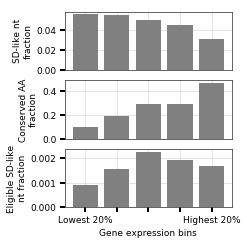

In [132]:
fig = plt.figure(figsize=(3.5,3.5))
ax = fig.add_subplot(311)
boxes = ax.bar([0, 1, 2, 3, 4], [np.mean(density_dict[i]) for i in ['lowest', 'low', 'mid', 'high', 'highest']], facecolor='0.5')
# ax.set_ylim(-0.01, 0.18)

ax.set_xticklabels('')
ax.set_ylabel('SD-like nt\nfraction')

for line in ax.xaxis.get_ticklines():
    line.set_markersize(0)
    line.set_markeredgewidth(0)

ax = fig.add_subplot(312)
boxes = ax.bar([0, 1, 2, 3, 4], [np.mean(basic_conservation_dict[i]) for i in ['lowest', 'low', 'mid', 'high', 'highest']], facecolor='0.5')
# ax.set_ylim(-0.01, 0.18)
ax.set_xticklabels('')
ax.set_ylabel('Conserved AA\nfraction')
for line in ax.xaxis.get_ticklines():
    line.set_markersize(0)
    line.set_markeredgewidth(0)

ax = fig.add_subplot(313)
boxes = ax.bar([0, 1, 2, 3, 4], [np.mean(eligible_density_dict[i]) for i in ['lowest', 'low', 'mid', 'high', 'highest']], facecolor='0.5')
ax.set_xticklabels('')
ax.set_ylabel('Eligible SD-like\nnt fraction')
ax.set_xticklabels(['', 'Lowest 20%', '', '', '', 'Highest 20%'], ha='center')
ax.set_xlabel('Gene expression bins')
plt.tight_layout(h_pad=-0.1)
# plt.savefig('../Results/Figures/expression_summary.pdf')

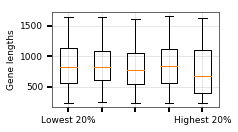

In [133]:
fig, ax = plt.subplots(figsize=(3,1.75))
boxes = ax.boxplot([length_dict[i] for i in ['lowest', 'low', 'mid', 'high', 'highest']])
ax.set_xticklabels(['Lowest 20%', '', '', '', 'Highest 20%'], ha='center')
ax.set_ylabel('Gene lengths')
plt.savefig('../Results/Figures/expression_bins_lengths_truncated.pdf', bbox_inches='tight')

# Run the gene-expression bins analysis

In [110]:
#####Parameters!
dicty_to_analyze = dicty_hyphy
threshold=-4.5
upper_threshold=-20
only_conserved_aa=True
position_limitation_dict=False
controls=('CODON', 'TRINT')
nt_strength_restriction='3'

randomizations=100


meta_codon = []
meta_trint = []
for cat in ['lowest', 'low', 'mid', 'high', 'highest']:
    
    #############################################################    
    #####TOGGLE ME TO SAVE DIFFERENT FILES ACCORDING TO WHETHER OR NOT TO CARE ABOUT GENE LENGTHS
#     file_name_modifiers = '{}_{}_Threshold={}to{}_Conserved={}_NtRestriction={}_Subset={}'.format('hyphy', species_name, upper_threshold, threshold, only_conserved_aa, nt_strength_restriction, cat)
    file_name_modifiers = '{}_{}_Threshold={}to{}_Conserved={}_NtRestriction={}_Subset={}_MIDDLELENGTHS'.format('hyphy', species_name, upper_threshold, threshold, only_conserved_aa, nt_strength_restriction, cat)
    #############################################################
    
    print('#####{}'.format(cat))
    subset_names = expression_quantile_dict[cat]
    actual_ratios_codon = []
    shuffled_ratios_codon = []
    actual_ratios_trint = []
    shuffled_ratios_trint = []

    actual_pvals_codon = []
    shuffled_pvals_codon = []
    actual_pvals_trint = []
    shuffled_pvals_trint = []
    for i in range(randomizations):
        print('#####{}'.format(i))
        sds_codon, others_codon, analyzed_sd_dict, analyzed_ctrl_dict, all_sds_codon, all_others_codon = paired_nt_analysis(dicty_to_analyze,\
                                         seq_dicty[base_genome],\
                                         fragment_energy_dict,\
                                         asd_seq,\
                                         conservation_dicty,\
                                         nt_conservation_dicty,\
                                         threshold=threshold,\
                                         upper_threshold=upper_threshold,\
                                         subset_names=subset_names,\
                                         only_conserved_aa=only_conserved_aa,\
                                         position_limitation_dict=position_limitation_dict,\
                                         internal_control=controls[0],\
                                         nt_strength_restriction=nt_strength_restriction)
        actual_ratios_codon.append(np.mean(sds_codon)/np.mean(others_codon))
        print('Lengths:{}, {}, Means:{}, {}, Ratio:{}'.format(len(sds_codon), len(others_codon),\
                                                              np.mean(sds_codon), np.mean(others_codon),\
                                                              np.mean(sds_codon)/np.mean(others_codon)))
        t_val, p_val = stats.wilcoxon(sds_codon, others_codon)
        actual_pvals_codon.append(p_val)

        combined = sds_codon + others_codon
        random.shuffle(combined)
        random_sds = combined[:len(sds_codon)]
        random_others = combined[len(sds_codon):]
        shuffled_ratios_codon.append(np.mean(random_sds)/np.mean(random_others))
        t_val_rand, p_val_rand = stats.wilcoxon(random_sds, random_others)
        shuffled_pvals_codon.append(p_val_rand)
        
        sds_trint, others_trint, analyzed_sd_dict, analyzed_ctrl_dict, all_sds_trint, all_others_trint = paired_nt_analysis(dicty_to_analyze,\
                                         seq_dicty[base_genome],\
                                         fragment_energy_dict,\
                                         asd_seq,\
                                         conservation_dicty,\
                                         nt_conservation_dicty,\
                                         threshold=threshold,\
                                         upper_threshold=upper_threshold,\
                                         subset_names=subset_names,\
                                         only_conserved_aa=only_conserved_aa,\
                                         position_limitation_dict=position_limitation_dict,\
                                         internal_control=controls[1],\
                                         nt_strength_restriction=nt_strength_restriction)
        actual_ratios_trint.append(np.mean(sds_trint)/np.mean(others_trint))
        print('Lengths:{}, {}, Means:{}, {}, Ratio:{}'.format(len(sds_trint), len(others_trint),\
                                                              np.mean(sds_trint), np.mean(others_trint),\
                                                              np.mean(sds_trint)/np.mean(others_trint)))
        
        t_val, p_val = stats.wilcoxon(sds_trint, others_trint)
        actual_pvals_trint.append(p_val)

        combined = sds_trint + others_trint
        random.shuffle(combined)
        random_sds = combined[:len(sds_trint)]
        random_others = combined[len(sds_trint):]
        shuffled_ratios_trint.append(np.mean(random_sds)/np.mean(random_others))

        t_val_rand, p_val_rand = stats.wilcoxon(random_sds, random_others)
        shuffled_pvals_trint.append(p_val_rand)
    
    df = pd.DataFrame({'Actual_rats_codon':actual_ratios_codon})
    df['Shuffled_rats_codon'] = shuffled_ratios_codon
    df['Actual_rats_trint'] = actual_ratios_trint
    df['Shuffled_rats_trint'] = shuffled_ratios_trint

    df['Actual_pvals_codon'] = actual_pvals_codon
    df['Shuffled_pvals_codon'] = shuffled_pvals_codon
    df['Actual_pvals_trint'] = actual_pvals_trint
    df['Shuffled_pvals_trint'] = shuffled_pvals_trint

    df['N_(codon)'] = len(sds_codon)
    df['N_(trint)'] = len(sds_trint)
    df.to_csv('../Results/Dataframes/df_{}_ratios.csv'.format(file_name_modifiers), index=False)


    dfA = pd.DataFrame({'SD-like(codon)':all_sds_codon})
    dfB = pd.DataFrame({'SD-like(trint)':all_sds_trint})
    dfC = pd.DataFrame({'Control\n(codon)':all_others_codon})
    dfD = pd.DataFrame({'Control\n(context)':all_others_trint})

    df = pd.concat([dfA,dfB,dfC,dfD], axis=1)
    df.to_csv('../Results/Dataframes/df_{}_all.csv'.format(file_name_modifiers), index=False)

#####lowest
#####0
Lengths:19, 19, Means:1.481172270433569, 1.9795062644834018, Ratio:0.7482533887409117
Lengths:15, 15, Means:1.4488760749457403, 1.849030863513483, Ratio:0.7835867445677038
#####1
Lengths:19, 19, Means:1.481172270433569, 1.7987198632290802, Ratio:0.8234591170714897
Lengths:15, 15, Means:1.4488760749457403, 2.312672278557524, Ratio:0.6264943322836226
#####2
Lengths:19, 19, Means:1.481172270433569, 2.2388009004363827, Ratio:0.6615917789495537
Lengths:15, 15, Means:1.4488760749457403, 2.03254559328957, Ratio:0.7128381669415883
#####3
Lengths:19, 19, Means:1.481172270433569, 2.6672510079356506, Ratio:0.5553179157217525
Lengths:15, 15, Means:1.4488760749457403, 1.7667617388746493, Ratio:0.8200744011292727
#####4
Lengths:19, 19, Means:1.481172270433569, 2.1685964791498704, Ratio:0.6830096261219679
Lengths:15, 15, Means:1.4488760749457403, 2.5354685388410414, Ratio:0.571443128853817
#####5
Lengths:19, 19, Means:1.481172270433569, 2.0818681774384147, Ratio:0.711463043859022
L

# Protein domain analysis

## Matching between PATRIC and RefSeq annotations

In [136]:
df = pd.read_csv('../Data/foldingFromPNAS_v2.csv')
df['bNumber'] = ''
df['patricNumber'] = ''
print('Original dataset size:', len(df.index))

for index in df.index:
    names = df.loc[index]['Gene names'].split(' ')
    for name in names:
        if name in reference_name_dict.keys():
            df.set_value(index, 'bNumber', name)
            try:
                df.set_value(index, 'patricNumber', reference_name_dict[name])
            except KeyError:
                pass

df = df[df['patricNumber'] != '']
print('Matched to PATRIC annotations:', len(df.index))


Original dataset size: 1236
Matched to PATRIC annotations: 1234


In [143]:
df

,Uniprot ID,Uniprot AC,Protein names,Gene names,Gene ontology (GO),Domain number,Quasi-equilibrium (arrested ribosome),Non-equilbrium (in vivo translation rates in E. coli doubling every 150 minutes),Lm (residues),_F_m / _A_m,...,Domain structural classification,Number of domains in this protein,Blattner_WT expression level,Lm (residues).1,bNumber,patricNumber,Domain_beg_nt,Domain_end_nt,Domain_beg_in_patric,Domain_end_in_patric
2,6PGD_ECOLI,P00350,"6-phosphogluconate dehydrogenase, decarboxylat...",gnd b2029 JW2011,D-gluconate metabolic process; NADP binding; p...,D1,co-translational,co-translational,14.0,138.02,...,alpha,2,0.000990079,-4.0,b2029,VBIEscCol129921_2106,6,540,6,540
3,ACCC_ECOLI,P24182,Biotin carboxylase (EC 6.3.4.14) (Acetyl-CoA c...,accC fabG b3256 JW3224,ATP binding; acetyl-CoA carboxylase activity; ...,D1,co-translational,co-translational,4.0,36.46,...,alpha-beta,3,0.000481856,-1.0,b3256,VBIEscCol129921_3355,3,255,3,255
4,ACCC_ECOLI,P24182,Biotin carboxylase (EC 6.3.4.14) (Acetyl-CoA c...,accC fabG b3256 JW3224,ATP binding; acetyl-CoA carboxylase activity; ...,D3,co-translational,co-translational,1.0,1.94,...,alpha-beta,3,0.000481856,0.0,b3256,VBIEscCol129921_3355,393,609,393,609
5,ACON2_ECOLI,P36683,Aconitate hydratase 2 (Aconitase) (EC 4.2.1.3)...,acnB yacI yacJ b0118 JW0114,2-methylisocitrate dehydratase activity; 4 iro...,D2,co-translational,co-translational,6.0,17.21,...,alpha,4,0.000607453,-1.0,b0118,VBIEscCol129921_0120,1590,2046,1512,1968
6,ACON2_ECOLI,P36683,Aconitate hydratase 2 (Aconitase) (EC 4.2.1.3)...,acnB yacI yacJ b0118 JW0114,2-methylisocitrate dehydratase activity; 4 iro...,D3,co-translational,co-translational,53.0,1144.83,...,alpha-beta,4,0.000607453,-23.0,b0118,VBIEscCol129921_0120,1206,1587,1128,1509
15,AK3_ECOLI,P08660,Lysine-sensitive aspartokinase 3 (EC 2.7.2.4) ...,lysC apk b4024 JW3984,ATP binding; amino acid binding; aspartate kin...,D2,co-translational,co-translational,4.0,21.39,...,alpha-beta,3,0.000265886,-1.0,b4024,VBIEscCol129921_4137,885,1155,891,1161
18,ALR1_ECOLI,P0A6B4,"Alanine racemase, biosynthetic (EC 5.1.1.1)",alr b4053 JW4013,D-alanine biosynthetic process; alanine racema...,D2,co-translational,co-translational,48.0,3262.80,...,alpha,2,3.08E-05,-22.0,b4053,VBIEscCol129921_4171,30,651,30,651
21,ARCA_ECOLI,P0A9Q1,Aerobic respiration control protein ArcA (Dye ...,arcA cpxC dye fexA msp seg sfrA b4401 JW4364,DNA binding; cytoplasm; intracellular; negativ...,D1,co-translational,co-translational,3.0,14.36,...,alpha,1,0.00034841,-2.0,b4401,VBIEscCol129921_4550,6,366,6,366
22,ARGR_ECOLI,P0A6D0,Arginine repressor,argR xerA b3237 JW3206,arginine binding; arginine biosynthetic proces...,D1,co-translational,co-translational,0.0,0.30,...,alpha,1,0.000154782,0.0,b3237,VBIEscCol129921_3334,3,234,3,234
23,ARLY_ECOLI,P11447,Argininosuccinate lyase (ASAL) (EC 4.3.2.1) (A...,argH b3960 JW3932,arginine biosynthetic process via ornithine; a...,D1,co-translational,co-translational,1.0,1.49,...,alpha,3,0.000179539,0.0,b3960,VBIEscCol129921_4081,9,321,9,321


In [149]:
dicty_to_analyze = dicty_hyphy

###Using annotations to establish domain boundaries
df['Domain_beg_nt'] = int()
df['Domain_end_nt'] = int()
for index in df.index:
    domain_beg, domain_end = df.loc[index]['Codon range of domain'].split('-')
    df.set_value(index, 'Domain_beg_nt', int(domain_beg)*3)
    df.set_value(index, 'Domain_end_nt', int(domain_end)*3)

###Matching those annotations to the PATRIC annotations
df['Domain_beg_in_patric'] = int()
df['Domain_end_in_patric'] = int()
for index in df.index[:]:    
    ###Grab the beginning and ending fragments in the RefSeq (20nts)
    ref_seq_beg = str(ref_genome_seq_ref_dict[df.loc[index]['bNumber']][int(df.loc[index]['Domain_beg_nt'])+10:int(df.loc[index]['Domain_beg_nt'])+30])
    ref_seq_end = str(ref_genome_seq_ref_dict[df.loc[index]['bNumber']][int(df.loc[index]['Domain_end_nt'])-30:int(df.loc[index]['Domain_end_nt'])-10])
    ###Determine their precise locations in PATRIC via EXACT string search of the fragments (throws out anything without an exact hit)
    if df.loc[index]['patricNumber'] in seq_dicty[base_genome].keys():
        df.set_value(index, 'Domain_beg_in_patric', seq_dicty[base_genome][df.loc[index]['patricNumber']].find(ref_seq_beg)-10)
        df.set_value(index, 'Domain_end_in_patric', seq_dicty[base_genome][df.loc[index]['patricNumber']].find(ref_seq_end) + 30)

df = df[df['Domain_beg_in_patric'] != 0]
df = df[df['Domain_end_in_patric'] != 0]
post_domain_dict = {}
for index in df.index[:]:
    temp_post_domain = []
    ###Skip any domain whose gene is not in the dictionary of rates
    if df.loc[index]['patricNumber'] not in dicty_to_analyze.keys():
        continue
    ###Skip any domain that occurs only at the very end of the sequences (to avoid true SD sites and 3' biases)
    if df.loc[index]['Domain_end_in_patric'] > len(dicty_to_analyze[df.loc[index]['patricNumber']])-50:
        pass
    ###For domains close to the end take all nucleotides after the domain but stop at 50 nts up stream of the gene end
    elif df.loc[index]['Domain_end_in_patric'] + 150 > len(dicty_to_analyze[df.loc[index]['patricNumber']])-50:
        temp_post_domain = list(range(df.loc[index]['Domain_end_in_patric'], len(dicty_to_analyze[df.loc[index]['patricNumber']])-50))
    ###For domains that aren't close to the end take the entire 150 nts after the domain
    else:
        temp_post_domain = list(range(df.loc[index]['Domain_end_in_patric'], df.loc[index]['Domain_end_in_patric']+150))
    
    ###Move on if the above process yielded nothing usable
    if temp_post_domain == []:
        continue

    if df.loc[index]['patricNumber'] not in post_domain_dict:
        post_domain_dict[df.loc[index]['patricNumber']] = []
        
    post_domain_dict[df.loc[index]['patricNumber']].extend(temp_post_domain)

print(len(post_domain_dict.keys()))    

to close to 3prime end
to close to 3prime end
to close to 3prime end
to close to 3prime end
to close to 3prime end
to close to 3prime end
to close to 3prime end
to close to 3prime end
to close to 3prime end
to close to 3prime end
to close to 3prime end
to close to 3prime end
to close to 3prime end
to close to 3prime end
to close to 3prime end
to close to 3prime end
to close to 3prime end
to close to 3prime end
to close to 3prime end
to close to 3prime end
to close to 3prime end
to close to 3prime end
to close to 3prime end
to close to 3prime end
to close to 3prime end
to close to 3prime end
to close to 3prime end
to close to 3prime end
to close to 3prime end
to close to 3prime end
to close to 3prime end
to close to 3prime end
to close to 3prime end
to close to 3prime end
to close to 3prime end
to close to 3prime end
to close to 3prime end
to close to 3prime end
to close to 3prime end
to close to 3prime end
to close to 3prime end
to close to 3prime end
to close to 3prime end
to close to

In [147]:
threshold=-4.5
upper_threshold=-20.0
only_conserved_aa=True
controls=('CODON', 'TRINT')


nt_strength_restriction='0'
# nt_strength_restriction='3'

randomizations = 3 

#########################################################
####Putative aSD sequence to use in considering hybridization energies
with open('../Data/json-energyRef-CCUCCU.txt') as infile:
    fragment_energy_dict = json.load(infile)
asd_seq = 'CCUCCU'
#########################################################
#########################################################
#
#
#
#########################################################
subset_names=post_domain_dict.keys()#####CRITICAL
position_limitation_dict=post_domain_dict####CRITICAL
file_name_modifiers = '{}_{}_Threshold={}to{}_Conserved={}_NtRestriction={}_Position_limitation=POST_DOMAIN_ALL'.format('hyphy', species_name, upper_threshold, threshold, only_conserved_aa, nt_strength_restriction)


#########################################################
#########################################################
#
#
#########################################################
#These containers are for keeping track of randomizations to assess significance
actual_ratios_codon = []
shuffled_ratios_codon = []
actual_ratios_trint = []
shuffled_ratios_trint = []

actual_pvals_codon = []
shuffled_pvals_codon = []
actual_pvals_trint = []
shuffled_pvals_trint = []


for i in range(randomizations):
    print('#####{}'.format(i))
    sds_codon, others_codon, analyzed_sd_dict, analyzed_ctrl_dict, all_sds_codon, all_others_codon = paired_nt_analysis(dicty_to_analyze,\
                                     seq_dicty[base_genome],\
                                     fragment_energy_dict,\
                                     asd_seq,\
                                     conservation_dicty,\
                                     nt_conservation_dicty,\
                                     threshold=threshold,\
                                     upper_threshold=upper_threshold,\
                                     subset_names=subset_names,\
                                     only_conserved_aa=only_conserved_aa,\
                                     position_limitation_dict=position_limitation_dict,\
                                     internal_control=controls[0],\
                                     nt_strength_restriction=nt_strength_restriction)
    actual_ratios_codon.append(np.mean(sds_codon)/np.mean(others_codon))
    print('Lengths:{}, {}, Means:{}, {}, Ratio:{}'.format(len(sds_codon), len(others_codon),\
                                                          np.mean(sds_codon), np.mean(others_codon),\
                                                          np.mean(sds_codon)/np.mean(others_codon)))

    t_val, p_val = stats.wilcoxon(sds_codon, others_codon)
    actual_pvals_codon.append(p_val)

    combined = sds_codon + others_codon
    random.shuffle(combined)
    random_sds = combined[:len(sds_codon)]
    random_others = combined[len(sds_codon):]
    shuffled_ratios_codon.append(np.mean(random_sds)/np.mean(random_others))
    t_val_rand, p_val_rand = stats.wilcoxon(random_sds, random_others)
    shuffled_pvals_codon.append(p_val_rand)

        
    sds_trint, others_trint, analyzed_sd_dict, analyzed_ctrl_dict, all_sds_trint, all_others_trint = paired_nt_analysis(dicty_to_analyze,\
                                     seq_dicty[base_genome],\
                                     fragment_energy_dict,\
                                     asd_seq,\
                                     conservation_dicty,\
                                     nt_conservation_dicty,\
                                     threshold=threshold,\
                                     upper_threshold=upper_threshold,\
                                     subset_names=subset_names,\
                                     only_conserved_aa=only_conserved_aa,\
                                     position_limitation_dict=position_limitation_dict,\
                                     internal_control=controls[1],\
                                     nt_strength_restriction=nt_strength_restriction)
    actual_ratios_trint.append(np.mean(sds_trint)/np.mean(others_trint))
    print('Lengths:{}, {}, Means:{}, {}, Ratio:{}'.format(len(sds_trint), len(others_trint),\
                                                          np.mean(sds_trint), np.mean(others_trint),\
                                                          np.mean(sds_trint)/np.mean(others_trint)))
    t_val, p_val = stats.wilcoxon(sds_trint, others_trint)
    actual_pvals_trint.append(p_val)

    combined = sds_trint + others_trint
    random.shuffle(combined)
    random_sds = combined[:len(sds_trint)]
    random_others = combined[len(sds_trint):]
    shuffled_ratios_trint.append(np.mean(random_sds)/np.mean(random_others))

    t_val_rand, p_val_rand = stats.wilcoxon(random_sds, random_others)
    shuffled_pvals_trint.append(p_val_rand)

#####0
Lengths:69, 69, Means:3.5063542029090464, 3.2667637720643254, Ratio:1.0733418292726198
48 6
Lengths:43, 43, Means:3.3104775380520715, 2.9682334779537456, Ratio:1.1153022707412705
32 4
#####1
Lengths:69, 69, Means:3.506354202909047, 3.0166524498821214, Ratio:1.1623328378600792
48 6
Lengths:43, 43, Means:3.310477538052071, 2.2663391869235756, Ratio:1.4607158351022702
32 4


In [148]:
tempy = []
for key,val in analyzed_sd_dict.items():
    if len(val) > 0:
        print(key, len(df[df['patricNumber']==key].index))
        tempy.append(len(df[df['patricNumber']==key].index))
print(len(tempy), len([i for i in tempy if i == 1]))

VBIEscCol129921_3866 4
VBIEscCol129921_0031 8
VBIEscCol129921_3521 2
VBIEscCol129921_0026 3
VBIEscCol129921_4308 4
VBIEscCol129921_3602 4
VBIEscCol129921_0244 3
VBIEscCol129921_3740 2
VBIEscCol129921_0083 3
VBIEscCol129921_0173 1
VBIEscCol129921_4086 2
VBIEscCol129921_0092 3
VBIEscCol129921_3355 3
VBIEscCol129921_4120 4
VBIEscCol129921_3830 1
VBIEscCol129921_0191 4
VBIEscCol129921_4081 3
VBIEscCol129921_3007 3
VBIEscCol129921_0012 4
VBIEscCol129921_2787 3
VBIEscCol129921_3854 2
VBIEscCol129921_0089 3
VBIEscCol129921_2692 2
VBIEscCol129921_4530 4
VBIEscCol129921_1836 5
VBIEscCol129921_3388 4
VBIEscCol129921_2271 1
VBIEscCol129921_4032 2
VBIEscCol129921_0003 1
VBIEscCol129921_2826 4
VBIEscCol129921_3929 6
VBIEscCol129921_1323 7
32 4


In [ ]:
df = pd.DataFrame({'Actual_rats_codon':actual_ratios_codon})
df['Shuffled_rats_codon'] = shuffled_ratios_codon
df['Actual_rats_trint'] = actual_ratios_trint
df['Shuffled_rats_trint'] = shuffled_ratios_trint

df['Actual_pvals_codon'] = actual_pvals_codon
df['Shuffled_pvals_codon'] = shuffled_pvals_codon
df['Actual_pvals_trint'] = actual_pvals_trint
df['Shuffled_pvals_trint'] = shuffled_pvals_trint

df['N_(codon)'] = len(sds_codon)
df['N_(trint)'] = len(sds_trint)
df.to_csv('../Results/Dataframes/df_{}_ratios.csv'.format(file_name_modifiers), index=False)


dfA = pd.DataFrame({'SD-like(codon)':all_sds_codon})
dfB = pd.DataFrame({'SD-like(trint)':all_sds_trint})
dfC = pd.DataFrame({'Control\n(codon)':all_others_codon})
dfD = pd.DataFrame({'Control\n(context)':all_others_trint})

df = pd.concat([dfA,dfB,dfC,dfD], axis=1)
df.to_csv('../Results/Dataframes/df_{}_all.csv'.format(file_name_modifiers), index=False)

# Put rates into context
Similar paired analysis of 2-fold vs 4-fold redundant codons

In [ ]:
genome_seq_dicty = seq_dicty[base_genome]
dicty_to_analyze = dicty_hyphy

ratios_all = []
for randomization in range(20):
    two_fold = []
    four_fold = []
    two_fold_all = []
    four_fold_all = []
    for gene_name, nt_sequence in list(genome_seq_dicty.items())[:]:
        if gene_name not in dicty_to_analyze.keys():
            continue
        two_fold_gene = []
        four_fold_gene = []
        codon_list = [nt_sequence[nt:nt+3] for nt in range(0, len(nt_sequence), 3)]
        for i, codon in enumerate(codon_list):
            if codon == '---':
                continue
            if i < 33:
                continue
            if i > len(codon_list)-16:
                continue
            if conservation_dicty[gene_name][i] != 'C':
                continue
            if codon in redundant_codons:
                four_fold_gene.append(dicty_to_analyze[gene_name][i*3+2])
            elif codon_to_aa_dict[codon] in ['F', 'D', 'E', 'K', 'N', 'Q', 'H', 'Y', 'C']:
                two_fold_gene.append(dicty_to_analyze[gene_name][i*3+2])
        smallest_set = min([len(two_fold_gene), len(four_fold_gene)])
        two_fold_truncated = random.sample(two_fold_gene, smallest_set)
        four_fold_truncated = random.sample(four_fold_gene, smallest_set)
        two_fold.extend(two_fold_truncated)
        four_fold.extend(four_fold_truncated)
        two_fold_all.extend(two_fold_gene)
        four_fold_all.extend(four_fold_gene)
    ratio_i = np.mean(four_fold)/np.mean(two_fold)
    ratios_all.append(ratio_i)
    print(randomization, 'Ratio:', ratio_i, 'Lengths:', len(four_fold), len(two_fold), len(two_fold_all), len(four_fold_all))
print(np.mean(four_fold_all)/np.mean(two_fold_all))

plt.figure()
plt.boxplot([two_fold, four_fold], showmeans=True);
plt.ylim(0,10)

# DEPRECATED CODE THAT I'D LIKE TO HANG ON TO AT THE MOMENT UNTIL I HAVE TIME TO GO THROUGH IT.

If you're looking at this page to re-create any analyses you'd be best to stop reading now. Unless you want a bit of a window into the mind of madness to see a few things I once tried / didn't have time (or feel the need) to go back through and re-assess importance of. 

In [ ]:
dicty_to_analyze = dicty_hyphy
threshold=-4.5
upper_threshold=-20
subset_names=False
only_conserved_aa=True
three_prime_analysis=False
controls=('CODON', 'TRINT')
# nt_strength_restriction=''
nt_strength_restriction='CURRENT_IS_WEAKEST'

#########################################################
####Putative aSD sequence to use in considering hybridization energies
with open('../Data/json-energyRef-CCUCCU.txt') as infile:
    fragment_energy_dict = json.load(infile)
asd_seq = 'CCUCCU'


x_sds_all = []
x_controls_all=[]
for i in range(2):
    sds, others, analyzed_sd_dict, analyzed_ctrl_dict = paired_nt_analysis(dicty_to_analyze,\
                                     seq_dicty[base_genome],\
                                     fragment_energy_dict,\
                                     asd_seq,\
                                     conservation_dicty,\
                                     threshold=threshold,\
                                     upper_threshold=upper_threshold,\
                                     randomization=False,\
                                     subset_names=subset_names,\
                                     only_conserved_aa=only_conserved_aa,\
                                     three_prime_analysis=three_prime_analysis,\
                                     internal_control=controls[0],\
                                     nt_strength_restriction=nt_strength_restriction)
    print(len(sds), len(others))
    nts_sds = []
    nts_controls = []
    for gene_name, positions in analyzed_sd_dict.items():
        for i in positions:
            ec_nt = seq_dicty[base_genome][gene_name][i]
            matches = []
            for genome in ordered_names:
                if seq_dicty[genome][gene_name][i] == ec_nt:
                    matches.append(1)
                else:
                    matches.append(0)
            nts_sds.append(matches)

    for gene_name, positions in analyzed_ctrl_dict.items():
        for i in positions:
            ec_nt = seq_dicty[base_genome][gene_name][i]
            matches = []
            for genome in ordered_names:
                if seq_dicty[genome][gene_name][i] == ec_nt:
                    matches.append(1)
                else:
                    matches.append(0)
            nts_controls.append(matches)
    nts_sds = nts_sds * np.exp(np.linspace(10, 1, 61))
    nts_sds = sorted(nts_sds, key=lambda x: np.sum(x))[::-1]
    nts_sds = nts_sds / np.exp(np.linspace(10, 1, 61))
    nts_controls = nts_controls * np.exp(np.linspace(10, 1, 61))
    nts_controls = sorted(nts_controls, key=lambda x: np.sum(x))[::-1]
    nts_controls = nts_controls / np.exp(np.linspace(10, 1, 61))
    
    x_sds_all.append(np.sum(nts_sds, axis=0)/np.shape(nts_sds)[0])
    x_controls_all.append(np.sum(nts_controls, axis=0)/np.shape(nts_sds)[0])

## Making figures from the above data

In [ ]:
from Bio import Phylo
tree = Phylo.read('../Data/Tree_files/Order_Enterobacterales_Mixed/RAxML_bestTree.MixedSet108seqs', 'newick')

In [ ]:
####Order strictly via branch length distance to base_genome
ordered_names = []
for i in tree.get_terminals():
    ordered_names.append((i.name, tree.distance(i.name, base_genome)))
ordered_names = sorted(ordered_names, key=lambda x: x[1])
ordered_names = [i[0] for i in ordered_names]

In [ ]:
###This needs to be written recursively to scale! in any meaningful way
###First order by the closest common ancestor to base_genome
initial_ordering = []
for i in tree.get_terminals():
    initial_ordering.append((i.name, len(tree.trace(tree.common_ancestor(i.name, base_genome), base_genome))))
initial_ordering = sorted(initial_ordering, key=lambda x: x[1])
###Resolve all ties by making whoever is closest to base_genome the top OR by making that call based on 
###who is closest via clades rather than distance. hmm
###Strictly speaking distance makes sense but can produce results that are not consistent with rotation
ordered_names = []
for i in range(1, max([dist for term,dist in initial_ordering])+1):
    tempy = [(term, dist) for term,dist in initial_ordering if dist == i]
    if len(tempy) == 1:
        ordered_names.append((tempy[0]))
    else:
        temp_ordering = []
        for blah in tempy:
            temp_ordering.append((blah[0],len(tree.trace(blah[0], base_genome))))
        temp_ordering = sorted(temp_ordering, key=lambda x: x[1])
        ordered_names.extend(temp_ordering)
ordered_names = [i for i,j in ordered_names]

In [ ]:
from matplotlib import gridspec

In [ ]:
fig = plt.figure(figsize=(12, 5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1]) 
ax1 = plt.subplot(gs[0])
ax1.matshow(np.array(nts_sds).T, cmap='Greys_r', aspect='auto', )
ax1.set_yticklabels('')
ax1.set_xticklabels('')
for line in ax1.xaxis.get_ticklines():
    line.set_markersize(0)
    line.set_markeredgewidth(0)
for line in ax1.yaxis.get_ticklines():
    line.set_markersize(0)
    line.set_markeredgewidth(0)
ax1.grid(False)
ax1.set_ylabel('Species\n(ordered phylogenetically)')
ax1.set_xlabel('Sample of 4-fold redundant sites')
ax1.spines['right'].set_visible(True)
ax1.spines['top'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_visible(True)

ax2 = plt.subplot(gs[1], sharey=ax1)
ax2.plot(np.sum(nts_sds, axis=0)/np.shape(nts_sds)[0], list(range(len(ordered_names))), c='k')
ax2.set_xlabel('ANI across 4-fold\nredundant sites')
# ax2.set_xlim(0.25, 1.01)
ax2.set_xticks([0.5, 1])
for line in ax2.yaxis.get_ticklines():
    line.set_markersize(0)
    line.set_markeredgewidth(0)
ax2.set_ylim(61,0)
plt.tight_layout()
plt.savefig('../Results/Figures/ANI_example.pdf')

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
yvals = list(range(len(ordered_names)))[::-1]
# x_sds = np.sum(nts_sds, axis=0)/np.shape(nts_sds)[0]
# x_controls = np.sum(nts_controls, axis=0)/np.shape(nts_sds)[0]
x_sds = np.mean(np.array(x_sds_all), axis=0)
x_controls = np.mean(np.array(x_controls_all), axis=0)
ax.plot(x_sds, yvals, label='SD-like', c='steelblue')
ax.plot(x_controls, yvals, label='Codon control', c='gray')
ax.fill_betweenx(yvals, x_sds, x_controls, where=x_sds>=x_controls, facecolor='steelblue', alpha=0.25)
ax.fill_betweenx(yvals, x_sds, x_controls, where=x_sds<x_controls, facecolor='lightgray', alpha=0.5)
ax.set_xlim(0.2,1.01)
ax.legend(fontsize=16, loc='best', framealpha=1)
ax.set_xlabel('ANI across 4-fold\nredundant sites')
ax.set_ylabel('Species (ordered phylogenetically)')
ax.set_yticklabels('');
# ax.set_ylabel('')

for line in ax.yaxis.get_ticklines():
    line.set_markersize(0)
    line.set_markeredgewidth(0)
plt.tight_layout()
plt.savefig('../Results/Figures/ANI_SD_CONSERVED_STRONGEST.pdf')

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
yvals = list(range(len(ordered_names)))[::-1]
# x_sds = np.sum(nts_sds, axis=0)/np.shape(nts_sds)[0]
# x_controls = np.sum(nts_controls, axis=0)/np.shape(nts_sds)[0]
x_sds = np.mean(np.array(x_sds_all), axis=0)
x_controls = np.mean(np.array(x_controls_all), axis=0)

for i in range(len(yvals)):
    if x_controls[i] > x_sds[i]:
        ax.plot([x_sds[i], x_controls[i]], [yvals[i], yvals[i]], c='lightgray', linewidth='3', alpha=0.5)
    else:
        ax.plot([x_sds[i], x_controls[i]], [yvals[i], yvals[i]], c='steelblue', linewidth='3', alpha=0.5)
ax.plot(x_sds, yvals, marker='o', linestyle='', label='SD-like', c='steelblue')
ax.plot(x_controls, yvals, marker='o', linestyle='', label='Control', c='gray')

# ax.fill_betweenx(yvals, x_sds, x_controls, where=x_sds>=x_controls, facecolor='steelblue', alpha=0.25)
# ax.fill_betweenx(yvals, x_sds, x_controls, where=x_sds<x_controls, facecolor='darkorange', alpha=0.25)
ax.set_xlim(0.2,1.01)
# ax.legend(fontsize=20, loc='best', framealpha=1)
ax.set_xlabel('ANI across 4-fold\nredundant sites')
ax.set_ylabel('Species (ordered phylogenetically)')
ax.set_yticklabels('');
# ax.set_ylabel('')

for line in ax.yaxis.get_ticklines():
    line.set_markersize(0)
    line.set_markeredgewidth(0)
plt.tight_layout()
plt.savefig('../Results/Figures/ANI_SD_CONSERVED_WEAKEST.pdf')

### For contingency tables

In [ ]:
ec_consensus = 0
ec_not_consensus = 0
for i in nts_sds:
    if np.median(i) == 1:
        ec_consensus += 1
    elif np.median(i) == 0:
        ec_not_consensus += 1
print(ec_consensus, ec_not_consensus)
ec_consensus = 0
ec_not_consensus = 0
for i in nts_controls:
    if np.median(i) == 1:
        ec_consensus += 1
    elif np.median(i) == 0:
        ec_not_consensus += 1
print(ec_consensus, ec_not_consensus)

In [ ]:
genome_grouping = 'representative'
df_rep = pd.read_csv('../../Genome_database/Data/Dataframes/PATRIC_genome_complete_bacteria_{}_taxon.csv'.format(genome_grouping), index_col = 'Genome ID')
df_rep = df_rep[(df_rep['order']=='Enterobacterales')  & (df_rep['PATRIC CDS'] > 2000)]
print(len(df_rep.index))

genome_grouping = 'reference'
df_ref = pd.read_csv('../../Genome_database/Data/Dataframes/PATRIC_genome_complete_bacteria_{}_taxon.csv'.format(genome_grouping), index_col = 'Genome ID')
df_ref = df_ref[(df_ref['order']=='Enterobacterales')  & (df_ref['PATRIC CDS'] > 2000)]
print(len(df_ref.index))

df = pd.concat([df_rep, df_ref])
print(len(df.index), len(list(set(list(df.index)))))

In [ ]:
for genome_name in seq_dicty.keys():
    print(genome_name, '&', df.loc[float(genome_name)]['Genome Name'], '\\\\')
    

In [40]:
blah = seq_dicty[base_genome]

In [44]:
blah['VBIEscCol129921_0002'].replace('-', '')

'ATGGTAAGAGTTTATGCCCCGGCTTCCAGCGCCAATATGAGCGTCGGATTTGATGTGCTCGGGGCGGCGGTAACCCCCGTAGACGGTTCGCTATTGGGCGATGTGGTCTCTGTTGAGCCAGCCGACCAGTTCAGTCTGAATAATCTTGGGCGCTTTGCTGACAAACTGCCTTCTGAGCCGCGAGAAAATATCGTCTATCAGTGCTGGGAGCGATTCTGTCAGGAACTGGGTAAAACCGTTCCGGTGGCAATGACGCTGGAAAAAAATATGCCGATTGGCTCCGGGTTAGGTTCCAGCGCCTGTTCCGTTGTGGCGGCGTTAGTCGCCATGAACGAGCACTGTGGGAAACCGCTCAACGACACGCGCCTGTTGGCGATCATGGGAGAGCTGGAAGGACGTATCTCCGGCAGTATTCATTACGATAATGTTGCCCCGTGCTTTTTGGGCGGTATGCAGTTAATGATCGAAGAAAACGGCATTATCAGCCAGCAGGTGCCAGGCTTTGATGAGTGGCTGTGGGTACTGGCGTATCCGGGGATTAAAGTGTCGACGGCGGAAGCGCGGGCCATTTTACCTGCGCAGTATCGCCGTCAGGACTGCATCGCCCACGGGCGGCATCTGGCAGGGTTTATCCATGCCTGCTATTCCCGTCAGCCTCTTCTGGCCGCGAAGCTGATGAAAGATGTCATCGCTGAGCCGTATCGTACCCGCTTGCTGCCAGGCTTCAGCCAGGCGCGTCAGGCGGTAGCGGAAATCGGCGCGTTGGCCAGCGGGATCTCCGGGTCAGGACCGACGCTGTTCGCCTTGTGCGATAAGCCGGATACGGCGCAGCGTGTTGCAGACTGGCTGGCTAAACATTATCTGCAAAATCAGGAAGGCTTTGTTCATATTTGCCGGTTGGACACGGCAGGCGCACGGGTACTGGGA'